## CS4100: Object Detction Project

This notebook is a proof of concept for our project. The intention of the project is to create a model that can detect pedestrians/people in an image and count the number of pedestrians. 

We will focus on creating and training a model that is capable of doing this and then we are going to compare it to some pre-trained models in some standard libraries.

Our data comes from https://github.com/liangzheng06/PRW-baseline, which is a free dataset of video frames with pedestrians. 

We will use the [Mask R-CNN](https://arxiv.org/abs/1703.06870) pre-trained model. We will use pytorch as the main library for the models (my laptop always has issues with tensorflow due to compatibility issues with Apple M2 chip).

In [19]:
import os
import torch
import cv2 as cv              # OpenCV library for image processing.
import numpy as np
import torch.utils.data       # for torch datasets
from PIL import Image         # to render images.
from scipy.io import loadmat  # for handling matlab files.
import warnings

# to clear output.
from IPython.display import clear_output 

# pre-trained model and Torch
import torchvision
from torchvision.transforms import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

warnings.filterwarnings('ignore')

In [2]:
# path to image folder.
img_path = 'PRW/frames'
# get the filenames.
img_names = os.listdir(img_path)

# print out some of the names.
print(img_names[:3])

['c1s4_033506.jpg', 'c3s1_109492.jpg', 'c6s1_024876.jpg']


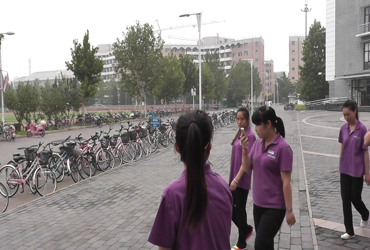

In [3]:
# display and image using PIL library
img_0 = Image.open(img_path+'/'+img_names[0])

# I'm making the image smaller (this will mess with aspect ratio).
img_0.resize((370, 250))

In [4]:
# check the color spcae of the image.
img_0.getbands()

('R', 'G', 'B')

In PyTorch you need to define a dataset. This makes using the data in PyTorch way easier. There are ceartain requirements that PyTorch needs in order to make a functioning class. 

The dataset should inherit from the standard torch.utils.data.Dataset class, and implement __len__ and __getitem__. The only specificity that we require is that the dataset __getitem__ should return:

- image: a PIL Image of size (H, W)
- target: a dict containing the following fields
  boxes (FloatTensor[N, 4]): the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W     and 0 to H
- labels (Int64Tensor[N]): the label for each bounding box
- image_id (Int64Tensor[1]): an image identifier. It should be unique between all the images in the dataset, and is     used during evaluation
- area (Tensor[N]): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the   metric scores between small, medium and large boxes.
- iscrowd (UInt8Tensor[N]): instances with iscrowd=True will be ignored during evaluation.
  (optionally) masks (UInt8Tensor[N, H, W]): The segmentation masks for each one of the objects
  (optionally) keypoints (FloatTensor[N, K, 3]): For each one of the N objects, it contains the K keypoints in [x, y, visibility] format, defining the object. visibility=0 means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt references/detection/transforms.py for your new keypoint representation
  
(I took the requirements off a jupyter notebook by PyTorch)

In [5]:
# set the path to the annotations folder.
annotations_path = 'PRW/annotations'

In [6]:
annotations = os.listdir(annotations_path)

# test loading an annotation.
annots = loadmat(annotations_path+'/'+annotations[0])
annots

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Feb 23 21:10:18 2016',
 '__version__': '1.0',
 '__globals__': [],
 'box_new': array([[857.        , 617.36075949, 145.71518987,  68.05063291,
         212.65822785],
        [880.        , 315.99090909, 108.5       ,  52.36363636,
         144.        ],
        [881.        , 478.31818182, 126.82727273,  47.12727273,
         140.07272727],
        [882.        , 422.02727273, 108.5       ,  49.74545455,
         140.07272727]])}

In [7]:
# get annotations for the test image.
ann = annotations[annotations.index(f'{img_names[0]}.mat')]
test_box = loadmat(annotations_path+'/'+ann)
boxes = test_box['box_new']

In [8]:
# display the boxes. The first element in each array is an ID.
# that ID belongs to the person in the IMG, -2 means unknown person.
# we can ignore this value.
boxes

array([[  -2.        ,  763.39416847,  456.52591793,   41.98704104,
          97.96976242],
       [  -2.        ,  803.04859611,  475.18682505,  405.87473002,
         594.81641469],
       [  -2.        , 1290.56479482,  449.52807775,  242.59179266,
         622.80777538],
       [  20.        , 1178.80875782,  466.49768847,  169.91509256,
         596.95353953],
       [  21.        , 1740.75917927,  426.20194384,  177.27861771,
         606.47948164]])

In [9]:
img_names[0], annotations[annotations.index(f'{img_names[0]}.mat')]

('c1s4_033506.jpg', 'c1s4_033506.jpg.mat')

Notes: In out case we want to focus on the last element in the annotation. This is an array of arrays where each array corresponds to the corners of the bounding box for a pedestrian. According to documentation, the bounding box coordinates are in the format [x, y, w, h].

Running the cell below will cause a GUI/pop-up to appear via a python application. The GUI will disappear on its own or if you hit any key in your keyboard after the GUI appears (uses OpenCV API).

In [10]:
# lets use openCV and check that the box coordinates make sense.
img = cv.imread(img_path+'/'+img_names[0])

# draw the rectangle
for box in boxes:
    mins = (int(box[1]), int(box[2]))
    maxs = (int(box[1])+int(box[3]), int(box[2])+int(box[4]))
    cv.rectangle(img, mins, maxs, (0, 0, 255), thickness=2)

# display the image.
cv.imshow('IMG1', img)

# you can change the value to 0. 
# this will make the GUI stay open 
# until you press a key on your keyboard.
cv.waitKey(8000)

# closes the GUI. 
cv.destroyWindow('IMG1')
cv.waitKey(1)

clear_output()

The code below comes from a sample notebook from PyTorch. Note sure what everything is doing, but I added the annoations to the dataset and deleted other stuff with we are not going to use.

In [11]:
class PRWDataset(torch.utils.data.Dataset):
    def __init__(self, img_root, ann_root, convert=True):
        self.convert = convert
        
        # paths.
        self.img_path = img_root
        self.annotations_path = ann_root
        
        # conversion and processing functions.
        self.transforms = T.ToTensor()
        get_files = lambda x: list(sorted(os.listdir(x)))
        
        # path to the image folder.
        self.imgs = get_files(self.img_path)
        self.anns = get_files(self.annotations_path)

    def __getitem__(self, idx):
        
        # load images and annotation.
        img_path = os.path.join(self.img_path, self.imgs[idx])
        ann_path = os.path.join(self.annotations_path, self.anns[idx])
        
        # its already in RGB, but just to be safe. 
        img = Image.open(img_path).convert("RGB")
        
        # we already have the bounding box info. 
        # so me need to load in the MAT file and read the annotations.
        ann = loadmat(ann_path)['box_new']
        
        # get bounding box coordinates for each mask.
        num_objs = len(ann)
        boxes = list()
        for box in ann:
            xmin = box[1]
            xmax = box[1] + box[3]
            ymin = box[2]
            ymax = box[2] + box[4]
            boxes.append([xmin, ymin, xmax, ymax])
        
        # convert the boxes into a tensor.
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.convert:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

Display what a dataset item looks like in memory. Just a dictionary with a bunch of tensors.

In [12]:
dataset = PRWDataset(img_path, annotations_path)
dataset[0]

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.5294, 0.5255, 0.5176],
          [1.0000, 1.0000, 1.0000,  ..., 0.5333, 0.5255, 0.5216],
          [1.0000, 1.0000, 1.0000,  ..., 0.5333, 0.5294, 0.5216],
          ...,
          [0.4902, 0.4902, 0.4863,  ..., 0.3412, 0.3451, 0.3490],
          [0.4902, 0.4863, 0.4824,  ..., 0.3373, 0.3451, 0.3529],
          [0.4902, 0.4863, 0.4784,  ..., 0.3608, 0.3686, 0.3765]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.5294, 0.5255, 0.5176],
          [1.0000, 1.0000, 1.0000,  ..., 0.5333, 0.5255, 0.5216],
          [1.0000, 1.0000, 1.0000,  ..., 0.5333, 0.5294, 0.5216],
          ...,
          [0.4824, 0.4824, 0.4784,  ..., 0.3255, 0.3294, 0.3333],
          [0.4824, 0.4784, 0.4745,  ..., 0.3216, 0.3294, 0.3373],
          [0.4824, 0.4784, 0.4706,  ..., 0.3451, 0.3529, 0.3608]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 0.5294, 0.5255, 0.5176],
          [1.0000, 1.0000, 1.0000,  ..., 0.5333, 0.5255, 0.5216],
          [1.0000, 1.0000, 1.0000,  ...,

Using the pre-trained model.

In [13]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [29]:
# set the device to CPU. My laptop has no GPU option, GPU is faster.
device = torch.device('cpu')

# pick one image from the test set
img, _ = dataset[1]

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [30]:
i = list(sorted(os.listdir(img_path)))[1]

In [32]:
boxes_i = prediction[0]['boxes']

# lets use openCV and check that the box coordinates make sense.
img = cv.imread(img_path+'/'+i)

# draw the rectangle
for box in boxes_i:
    mins = (int(box[0]), int(box[1]))
    maxs = (int(box[0])+int(box[2]), int(box[1])+int(box[3]))
    cv.rectangle(img, mins, maxs, (0, 0, 255), thickness=2)

In [33]:
# display the image.
cv.imshow('IMG1', img)

# you can change the value to 0. 
# this will make the GUI stay open 
# until you press a key on your keyboard.
cv.waitKey(1000)

# closes the GUI. 
cv.destroyWindow('IMG1')
cv.waitKey(1)

clear_output()